In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

In [21]:
from tensorflow.keras.models import Model

def visualize_layer_outputs(model, image, n):
    """
    Pass an image through the first `n` layers of the model and plot output channels.

    Parameters:
    - model: Keras Sequential model
    - image: single input image (shape must match model input)
    - n: number of layers to include
    """
    # Ensure image has batch dimension
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)

    # Create a model up to the nth layer
    truncated_model = Model(inputs=model.input, outputs=model.layers[n].output)

    # Get activations
    activations = truncated_model.predict(image)
    
    # Squeeze batch dimension if needed
    if activations.ndim == 4:
        activations = np.squeeze(activations, axis=0)  # shape: (H, W, C)

    n_channels = activations.shape[-1]

    # Set up subplot grid
    n_cols = 4
    n_rows = int(np.ceil((n_channels + 1) / n_cols))  # +1 for original image
    size = 4
    
    plt.figure(figsize=(size * n_cols, size * n_rows))

    # Plot original image
    plt.subplot(n_rows, n_cols, 1)
    if image.shape[-1] == 1:
        plt.imshow(image[0, ..., 0], cmap='gray')
    else:
        plt.imshow(image[0])
    plt.title("Original")
    plt.axis('off')

    # Plot each channel
    for i in range(n_channels):
        plt.subplot(n_rows, n_cols, i + 2)
        plt.imshow(activations[..., i], cmap='gray', interpolation=None)
        plt.title(f"Channel {i}")

    plt.tight_layout()
    plt.show()

# Keras CNN on un-augmented MNIST data

In [4]:
from tensorflow.keras.datasets import mnist

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (60000, 28, 28, 1)
X_test.shape:  (10000, 28, 28, 1)


## Create/train/analyze model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dropout_rate = 0.1

n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=X_train.shape[1:]),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    GlobalAveragePooling2D(),
    
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax'),
])

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                        

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
938/938 [==============================] - 8s 8ms/step - loss: 1.3096 - accuracy: 0.5542 - val_loss: 0.5590 - val_accuracy: 0.8049
Epoch 2/10
938/938 [==============================] - 7s 8ms/step - loss: 0.3999 - accuracy: 0.8695 - val_loss: 0.2445 - val_accuracy: 0.9229
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.2494 - accuracy: 0.9248 - val_loss: 0.3707 - val_accuracy: 0.8748
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.2265 - accuracy: 0.9316 - val_loss: 0.3055 - val_accuracy: 0.9130
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1965 - accuracy: 0.9402 - val_loss: 0.2556 - val_accuracy: 0.9270
Epoch 6/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1947 - accuracy: 0.9409 - val_loss: 0.1769 - val_accuracy: 0.9497
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.1785 - accuracy: 0.9467 - val_loss: 0.1589 - val_accuracy: 0.9537
Epoch 

313/313 [==============================] - 1s 2ms/step


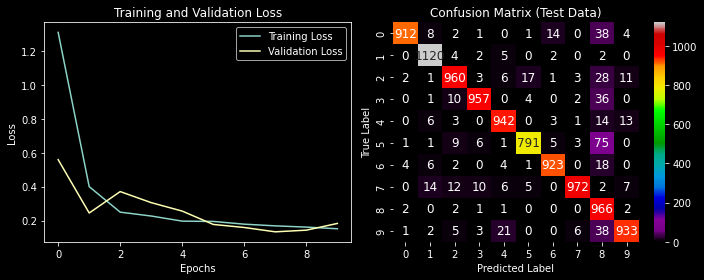

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.93      0.94      1032
           3       0.97      0.95      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.97      0.89      0.92       892
           6       0.97      0.96      0.97       958
           7       0.98      0.95      0.96      1028
           8       0.79      0.99      0.88       974
           9       0.96      0.92      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

## Visualize channels after processing

1/1 [==============================] - 0s 27ms/step


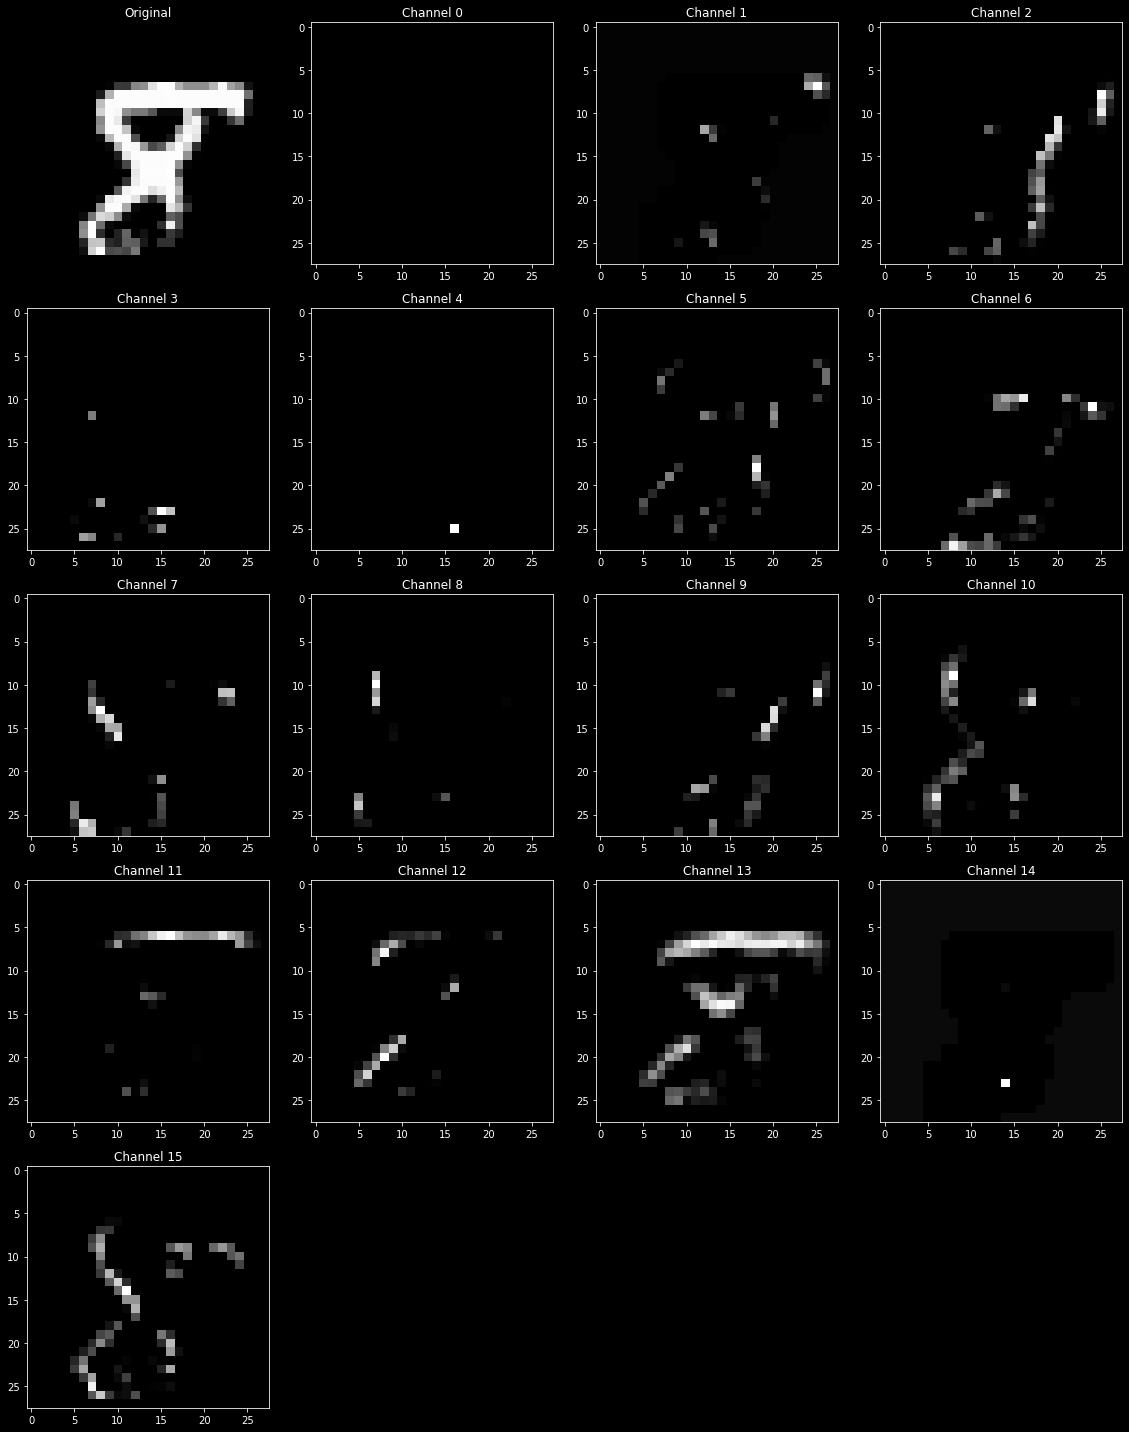

In [26]:
idx = np.random.choice( range(X_train.shape[0]), 1 )[0]

# Choose an image from your dataset
sample_img = X_train[idx]  # or any image shaped like your input

# Visualize up to the 2nd Conv2D layer (index 2)
visualize_layer_outputs(model, sample_img, n=0)

# Keras CNN on augmented MNIST data

In [15]:
from tensorflow.keras.datasets import mnist

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (60000, 28, 28, 1)
X_test.shape:  (10000, 28, 28, 1)


## Create/train/analyze model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dropout_rate = 0.1

n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=X_train.shape[1:]),

    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    
    GlobalAveragePooling2D(),
    
    Dense(32, activation='relu'),
    Dropout(dropout_rate),
    Dense(16, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Display model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 8)        0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                      

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image generator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=30,      # Rotate images randomly
    width_shift_range=0.2,  # Randomly shift the width of images
    height_shift_range=0.2, # Randomly shift the height of images
    zoom_range=0.2,         # Randomly zoom
    shear_range=0.1         # Apply shear transformation
)

In [24]:
history = model.fit(
    datagen.flow(
        X_train, y_train,
        batch_size=64
        ),
    epochs=10,
    validation_data=datagen.flow(
        X_test, y_test
        ),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
938/938 [==============================] - 15s 15ms/step - loss: 0.7578 - accuracy: 0.7412 - val_loss: 0.2639 - val_accuracy: 0.9207
Epoch 2/10
938/938 [==============================] - 14s 15ms/step - loss: 0.3249 - accuracy: 0.8999 - val_loss: 0.3060 - val_accuracy: 0.9093
Epoch 3/10
938/938 [==============================] - 14s 15ms/step - loss: 0.2454 - accuracy: 0.9270 - val_loss: 0.2307 - val_accuracy: 0.9305
Epoch 4/10
938/938 [==============================] - 14s 15ms/step - loss: 0.2184 - accuracy: 0.9348 - val_loss: 0.1722 - val_accuracy: 0.9472
Epoch 5/10
938/938 [==============================] - 14s 15ms/step - loss: 0.1940 - accuracy: 0.9427 - val_loss: 0.1723 - val_accuracy: 0.9492
Epoch 6/10
938/938 [==============================] - 14s 15ms/step - loss: 0.1835 - accuracy: 0.9470 - val_loss: 0.2822 - val_accuracy: 0.9174
Epoch 7/10
938/938 [==============================] - 14s 15ms/step - loss: 0.1777 - accuracy: 0.9488 - val_loss: 0.1554 - val_accuracy:

313/313 [==============================] - 1s 2ms/step


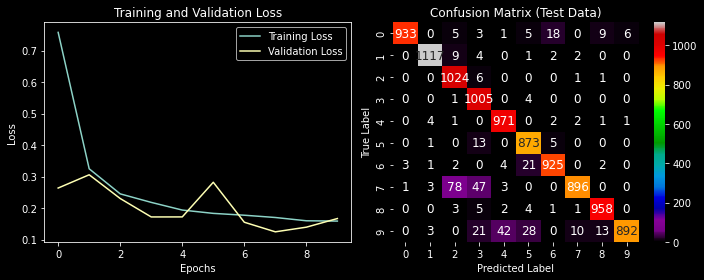

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.91      0.99      0.95      1032
           3       0.91      1.00      0.95      1010
           4       0.95      0.99      0.97       982
           5       0.93      0.98      0.96       892
           6       0.97      0.97      0.97       958
           7       0.98      0.87      0.92      1028
           8       0.97      0.98      0.98       974
           9       0.99      0.88      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

## Visualize channels after processing

1/1 [==============================] - 0s 27ms/step


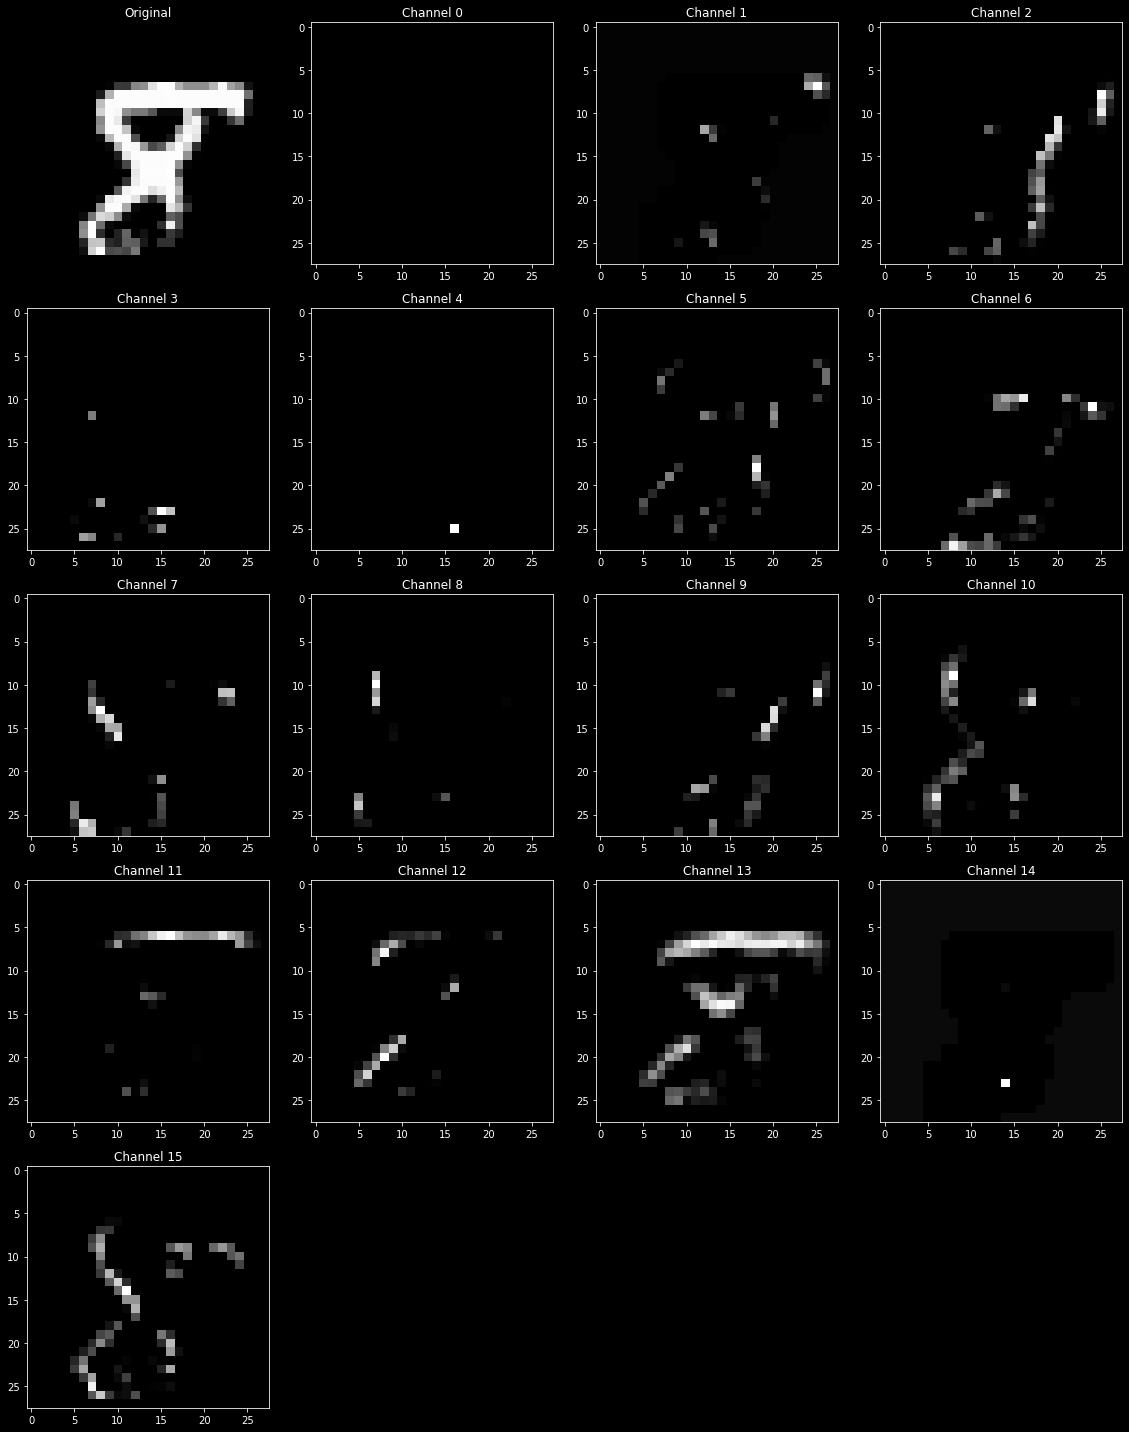

In [26]:
idx = np.random.choice( range(X_train.shape[0]), 1 )[0]

# Choose an image from your dataset
sample_img = X_train[idx]  # or any image shaped like your input

# Visualize up to the 2nd Conv2D layer (index 2)
visualize_layer_outputs(model, sample_img, n=0)